In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob, os
from datetime import datetime
import SimpleITK as sitk
from MRLCinema.registration.create_mask import create_registration_mask, create_grid
from MRLCinema.readcine.readcines import readcines, SliceDirection, resample_cine_to_identity 
from MRLCinema.readcine.read_mask import read_patient_ID  

from MRLCinema.registration.crop import crop_sequence, crop_image, find_crop_box
from MRLCinema.registration.group import group_registration_elastix
from MRLCinema.extract_motion import extract_motion
from MRLCinema.motion_statistics import motion_statistics
from U2Dose.patient.Roi import Roi
from U2Dose.dicomio.rtstruct import RtStruct
from U2Dose.dicomio.rtplan import RtPlan

import pydicom


In [2]:
import SimpleITK as sitk

'Elastix' in dir(sitk)

True

In [2]:

def find_structure_set(patient_ID, timestamp) -> RtStruct|None:
    patient_root= f'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/PATIENT_DATA'
    rtss_filenames = glob.glob(os.path.join(patient_root, patient_ID, '*', 'RS*.dcm'))
    for filename in rtss_filenames:
        rtss_dcm = pydicom.dcmread(filename)
        rtss_study_date = datetime(int(rtss_dcm.StudyDate[0:4]), int(rtss_dcm.StudyDate[4:6]), int(rtss_dcm.StudyDate[6:8])).date()
        
        if rtss_study_date == timestamp.date():
            rtss = RtStruct(filename)
            rtss.parse()
            return rtss
    return None

def find_plan(patient_ID, timestamp) -> RtStruct|None:
    patient_root= f'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/PATIENT_DATA'
    rtplan_filenames = glob.glob(os.path.join(patient_root, patient_ID, '*', 'RP*.dcm'))
    for filename in rtplan_filenames:
        rtplan_dcm = pydicom.dcmread(filename)
        rtplan_study_date = datetime(int(rtplan_dcm.StudyDate[0:4]), int(rtplan_dcm.StudyDate[4:6]), int(rtplan_dcm.StudyDate[6:8])).date()
        
        if rtplan_study_date == timestamp.date():
            rtplan = RtPlan(filename)
            rtplan.parse()
            return rtplan
    return None


def construct_zmm(rtss, grid):
    return Roi.from_rtstruct(rtss, name='Z_MM', grid=grid)

filename = '/home/david/source/QAckis/QAckis/TestData/cine/example.bin'
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/cines'
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/1.3.46.670589.11.79101.5.0.17796.2024112811114308006'
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/1.3.46.670589.11.79101.5.0.16236.2024102909043045002'
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/1.3.46.670589.11.79101.5.0.17796.2024112808532524002'



In [3]:


cine_directory = os.path.join(path, 'TwoDImages')

import time
start = time.time()
cines = readcines(cine_directory, max_n=1500)
print(time.time()-start, len(cines))

#time_sorted_cines = sorted(cines, key=lambda cine: cine.timestamp)

#time_sorted_transversal = list(filter(lambda cine: cine.direction == SliceDirection.TRANSVERSAL, time_sorted_cines))
#time_sorted_coronal = list(filter(lambda cine: cine.direction == SliceDirection.CORONAL, time_sorted_cines))
#time_sorted_sagittal = list(filter(lambda cine: cine.direction == SliceDirection.SAGITTAL, time_sorted_cines))
#time_sorted_transversal =[ resample_cine_to_identity(cine) for cine in time_sorted_transversal]
#time_sorted_coronal =[ resample_cine_to_identity(cine) for cine in time_sorted_coronal]
#time_sorted_sagittal =[ resample_cine_to_identity(cine) for cine in time_sorted_sagittal] 

#print(time.time()-start)

#len(time_sorted_transversal), len(time_sorted_coronal), len(time_sorted_sagittal)
#time_sorted_transversal[0].image.GetDirection(), time_sorted_coronal[0].image.GetDirection(), time_sorted_sagittal[0].image.GetDirection()
#time_sorted_transversal[0].image.GetSize(), time_sorted_coronal[0].image.GetSize(), time_sorted_sagittal[0].image.GetSize()
#time_sorted_transversal[0].image.GetSpacing(), time_sorted_coronal[0].image.GetSpacing(), time_sorted_sagittal[0].image.GetSpacing()

18.611377954483032 1500


In [5]:


patient_ID = read_patient_ID(path)
print(patient_ID)

print('find rtss')
rtss = find_structure_set(patient_ID, cines[0].timestamp)
print(rtss.all_roi_names())

print('find rtplan')
rtplan = find_plan(patient_ID, cines[0].timestamp)

rtss.all_roi_names()



194202130656
find rtss
['PTVT_42.7', 'Z_MM', 'External', 'Z_External', 'Rectum', 'PenileBulb', 'Femur_R(Upper)', 'Femur_L(Upper)', 'Bladder', 'Z_Bone', 'CTVT_42.7', 'Z1-Bridge', 'Z10-Couch Support', 'Z2a-Bridge', 'Z2b-Bridge', 'Z3-Bridge', 'Z4-Couch Support', 'Z5-Hard-plate', 'Z6-Couch Support', 'Z7-Couch Support', 'Z8-Mattress']
find rtplan


['PTVT_42.7',
 'Z_MM',
 'External',
 'Z_External',
 'Rectum',
 'PenileBulb',
 'Femur_R(Upper)',
 'Femur_L(Upper)',
 'Bladder',
 'Z_Bone',
 'CTVT_42.7',
 'Z1-Bridge',
 'Z10-Couch Support',
 'Z2a-Bridge',
 'Z2b-Bridge',
 'Z3-Bridge',
 'Z4-Couch Support',
 'Z5-Hard-plate',
 'Z6-Couch Support',
 'Z7-Couch Support',
 'Z8-Mattress']

In [ ]:
grid = create_grid(time_sorted_transversal[0], time_sorted_coronal[0], time_sorted_sagittal[0])
grid.pos_000, grid.spacing, grid.dim
print('constrict z_mm volume')
z_mm = construct_zmm(rtss, grid)
print('constrict ctv volume')
ctv = Roi.from_rtstruct(rtss, name='CTVT_42.7', grid=grid)
#ctv = Roi.from_rtstruct(rtss, name='CTV', grid=grid)
print('constrict rectum volume')
rectum = Roi.from_rtstruct(rtss, name='Rectum', grid=grid)
#bladder = Roi.from_rtstruct(rtss, name='Bladder', grid=grid)
#external = Roi.from_rtstruct(rtss, name='External', grid=grid)
#union = z_mm.mask + 2*rectum.mask + 3*bladder.mask

#print('mask dilation')
#registration_mask_3d = mask_dilation(z_mm.mask, grid.pos_000, grid.spacing, dilation_distance=10)


constrict z_mm volume
constrict ctv volume
constrict rectum volume


(1, 336, 336)


(50.0, 275.0)

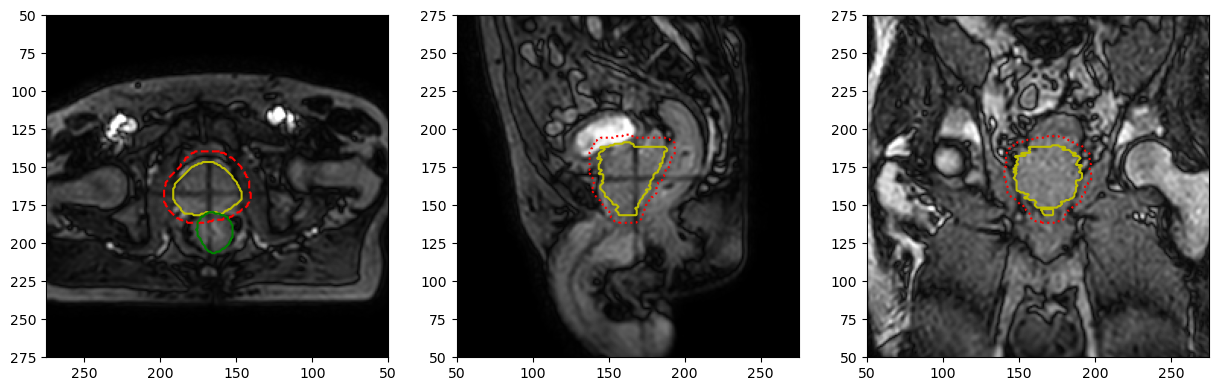

In [27]:

f, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(15, 10))

ax4.imshow(sitk.GetArrayFromImage(time_sorted_transversal[0].image[:,:,0])[:,:], cmap='gray')
#ax4.imshow(sitk.GetArrayFromImage(time_sorted_transversal[0].mask[:,:,0])[:,:], cmap='gray', alpha=0.5)
ax4.contour(z_mm.mask[:,:,168].T, levels=[0.5], colors='r', linestyles='dashed')
ax4.contour(ctv.mask[:,:,168].T, levels=[0.5], colors='y')
ax4.contour(rectum.mask[:,:,168].T, levels=[0.5], colors='g')
ax4.set_xlim([275, 50])
ax4.set_ylim([275, 50])

print(time_sorted_sagittal[0].image.GetSize())

ax5.imshow(sitk.GetArrayFromImage(time_sorted_sagittal[0].image[0,:,:]), cmap='gray')
#ax5.imshow(sitk.GetArrayFromImage(time_sorted_sagittal[0].mask[0,:,:]), cmap='gray', alpha=0.5)
ax5.contour(z_mm.mask[168,:,:].T, levels=[0.5], colors='r', linestyles='dotted')
ax5.contour(ctv.mask[168,:,:].T, levels=[0.5], colors='y')
ax5.set_xlim([50, 275])
ax5.set_ylim([50, 275])

ax6.imshow(sitk.GetArrayFromImage(time_sorted_coronal[0].image[:,0,:]), cmap='gray')
#ax6.imshow(sitk.GetArrayFromImage(time_sorted_coronal[0].mask[:,0,:]), cmap='gray', alpha=0.5)
ax6.contour(z_mm.mask[:,168,:].T, levels=[0.5], colors='r', linestyles='dotted')
ax6.contour(ctv.mask[:,168,:].T, levels=[0.5], colors='y')
ax6.set_xlim([50, 275])
ax6.set_ylim([50, 275])



#ax6.contour(rectum.mask[168,:,:].T, levels=[0.5], colors='g')
#ax6.contour(bladder.mask[168,:,:].T, levels=[0.5], colors='y')

#X-axis: Increases from the patient's right to left.
#Y-axis: Increases from the patient's anterior (front) to posterior (back).
#Z-axis: Increases from the patient's feet to head12.

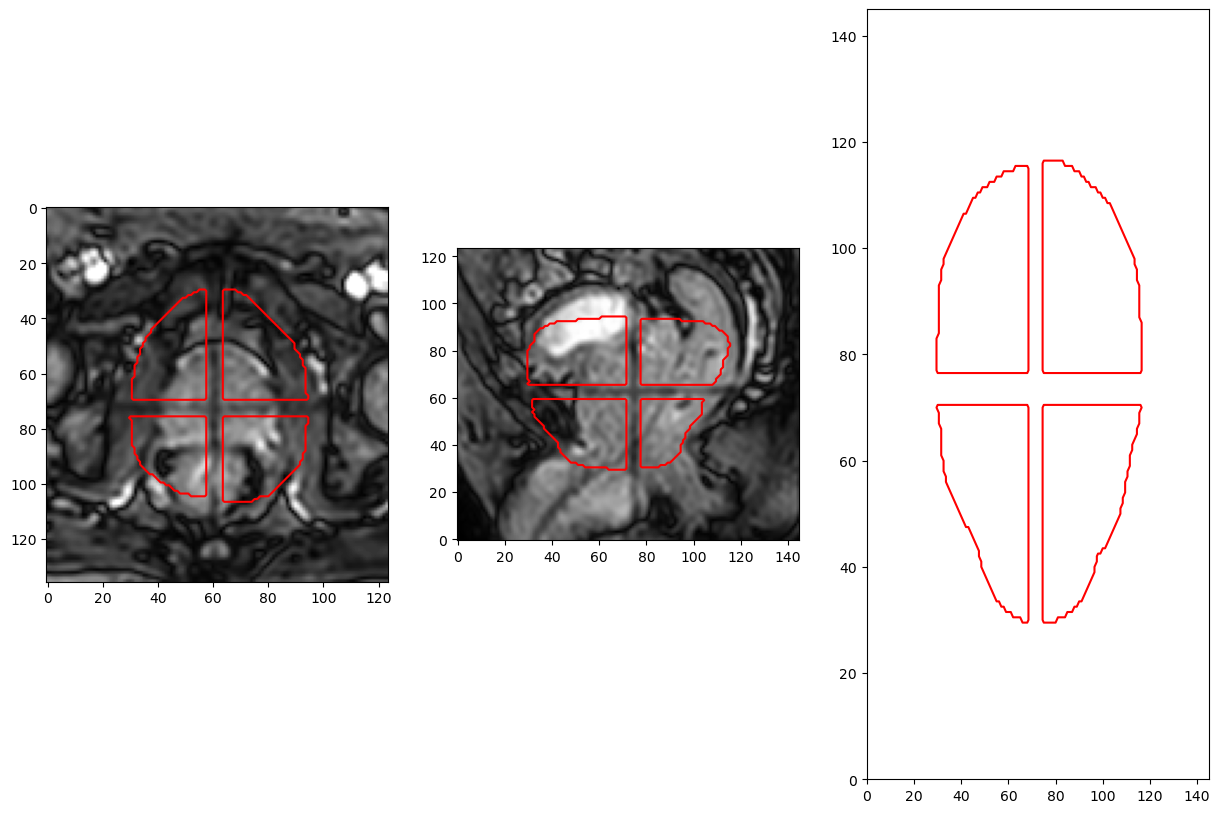

In [34]:
#
# Crop images
#

pos_000 = grid.pos_000

mask_transversal = create_registration_mask(z_mm, time_sorted_transversal[0])
crop_box = find_crop_box(mask_transversal, m=30)
cines_transversal_cropped = crop_sequence(time_sorted_transversal, crop_box)
mask_transversal_cropped = crop_image(mask_transversal, crop_box)
mask_transversal_cropped = sitk.Cast(mask_transversal_cropped, sitk.sitkUInt8)

mask_sagittal = create_registration_mask(z_mm, time_sorted_sagittal[0])
crop_box = find_crop_box(mask_sagittal, m=30)
cines_sagittal_cropped = crop_sequence(time_sorted_sagittal, crop_box)
mask_sagittal_cropped = crop_image(mask_sagittal, crop_box)
mask_sagittal_cropped = sitk.Cast(mask_sagittal_cropped, sitk.sitkUInt8)

mask_coronal = create_registration_mask(z_mm, time_sorted_coronal[0])
crop_box = find_crop_box(mask_coronal, m=30)
cines_coronal_cropped = crop_sequence(time_sorted_coronal, crop_box)
mask_coronal_cropped = crop_image(mask_coronal, crop_box)
mask_coronal_cropped = sitk.Cast(mask_coronal_cropped, sitk.sitkUInt8)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

ax1.imshow(sitk.GetArrayFromImage(cines_transversal_cropped[10])[0], cmap='gray')
ax1.contour(sitk.GetArrayFromImage(mask_transversal_cropped)[0], levels=[0.5], colors='r')

ax2.imshow(sitk.GetArrayFromImage(cines_sagittal_cropped[10]), cmap='gray', origin='lower')
ax2.contour(sitk.GetArrayFromImage(mask_sagittal_cropped)[:,:,0], levels=[0.5], colors='r')

#ax3.imshow(sitk.GetArrayFromImage(cines_coronal_cropped[10]).reshape(149, 142), cmap='gray', origin='lower')
ax3.contour(sitk.GetArrayFromImage(mask_coronal_cropped)[:,0,:], levels=[0.5], colors='r')


#sz = mask_transversal_cropped.GetSize()
#ax1.set_ylim([0, sz[0]])
#ax1.set_xlim([0, sz[1]])

#sz = mask_sagittal_cropped.GetSize()
#ax2.set_ylim([0, sz[0]])
#ax2.set_xlim([0, sz[1]])

#sz = mask_coronal_cropped.GetSize()
#ax3.set_ylim([0, sz[0]])
#ax3.set_xlim([0, sz[1]])



In [6]:
time_transversal, displacements_transversal, time_sagittal, displacements_sagittal, time_coronal, displacements_coronal = extract_motion(cines, rtss=rtss, max_n=1500) 

image info (-77.52899867296219, -57.70499688386917, 0.0) (1.2979999780654907, 1.2979999780654907, 1.0) (124, 136, 507) 2 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
mask info (-77.52899867296219, -57.70499688386917, 0.0) (1.2979999780654907, 1.2979999780654907, 1.0) (124, 136, 507) 1 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

start parameter map
ParameterObject (0x36da1c60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 276124
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (AutomaticParameterEstimation "true")
  (CheckNumberOfSamples "true")
  (DefaultPixelValue 0)
  (FinalBSplineInterpolationOrder 3)
  (FinalGridSpacingInPhysicalUnits 8)
  (FixedImagePyramid "FixedSmoothingImagePyramid")
  (GridSpacingSchedule 2.80322 1.9881 1.41 1)
  (ImageSampler "RandomCoordinate")
  (Interpolator "ReducedDimensionBSplineInterpolator")
  (MaximumNumberOfIterations 256)
  (MaximumNumberOfSamplingAttempts 8)
  (Metric "VarianceOverLastD

In [35]:

import time
start = time.time()
resultImage, transformParameterMap_transversal = group_registration_elastix(cines_transversal_cropped, mask_transversal_cropped, time_sorted_transversal[0].direction) 
resultImage, transformParameterMap_sagittal = group_registration_elastix(cines_sagittal_cropped, mask_sagittal_cropped, time_sorted_sagittal[0].direction)
resultImage, transformParameterMap_coronal = group_registration_elastix(cines_coronal_cropped, mask_coronal_cropped, time_sorted_coronal[0].direction)
#end = time.time()
#print(end - start)

#
# Save the transformation parameters
#
#filename_transversal = '/home/david/source/MRLCinema/transform_parameter_map_transversal.txt'
#sitk.WriteParameterFile(transformParameterMap_transversal[0], filename_transversal)
#filename_sagittal = '/home/david/source/MRLCinema/transform_parameter_map_sagittal.txt'
#sitk.WriteParameterFile(transformParameterMap_sagittal[0], filename_sagittal)
#filename_coronal = '/home/david/source/MRLCinema/transform_parameter_map_coronal.txt'
#sitk.WriteParameterFile(transformParameterMap_coronal[0], filename_coronal)


#resultImage, transformParameterMap_transversal = group_registration_elastix(cines_transversal_cropped, mask_transversal_cropped, filename_transversal)
#resultImage, transformParameterMap_sagittal = group_registration_elastix(cines_sagittal_cropped, mask_sagittal_cropped, filename_sagittal)
#resultImage, transformParameterMap_coronal = group_registration_elastix(cines_coronal_cropped, mask_coronal_cropped, filename_coronal)




image info (-77.52899867296219, -57.70499688386917, 0.0) (1.2979999780654907, 1.2979999780654907, 1.0) (124, 136, 507) 2 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
mask info (-77.52899867296219, -57.70499688386917, 0.0) (1.2979999780654907, 1.2979999780654907, 1.0) (124, 136, 507) 1 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

start parameter map
ParameterObject (0x3a2fb9d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 1207180
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (AutomaticParameterEstimation "true")
  (CheckNumberOfSamples "true")
  (DefaultPixelValue 0.000000)
  (FinalBSplineInterpolationOrder 3.000000)
  (FinalGridSpacingInPhysicalUnits 8.000000)
  (FixedImagePyramid "FixedSmoothingImagePyramid")
  (GridSpacingSchedule 2.803221 1.988100 1.410000 1.000000)
  (ImageSampler "RandomCoordinate")
  (Interpolator "ReducedDimensionBSplineInterpolator")
  (MaximumNumberOfIterations 256.000000)
  (MaximumNumberOfSampl

In [ ]:

displacements_transversal = parameter_map_to_displacements(transformParameterMap_transversal[0], reset_first=True)
displacements_sagittal = parameter_map_to_displacements(transformParameterMap_sagittal[0], reset_first=True)
displacements_coronal = parameter_map_to_displacements(transformParameterMap_coronal[0], reset_first=True)



motion_statistics(displacements_transversal, displacements_sagittal, displacements_coronal, percentile=0.98)

(0.5398420500000001, 0.57707285, 2.0913872500000004)

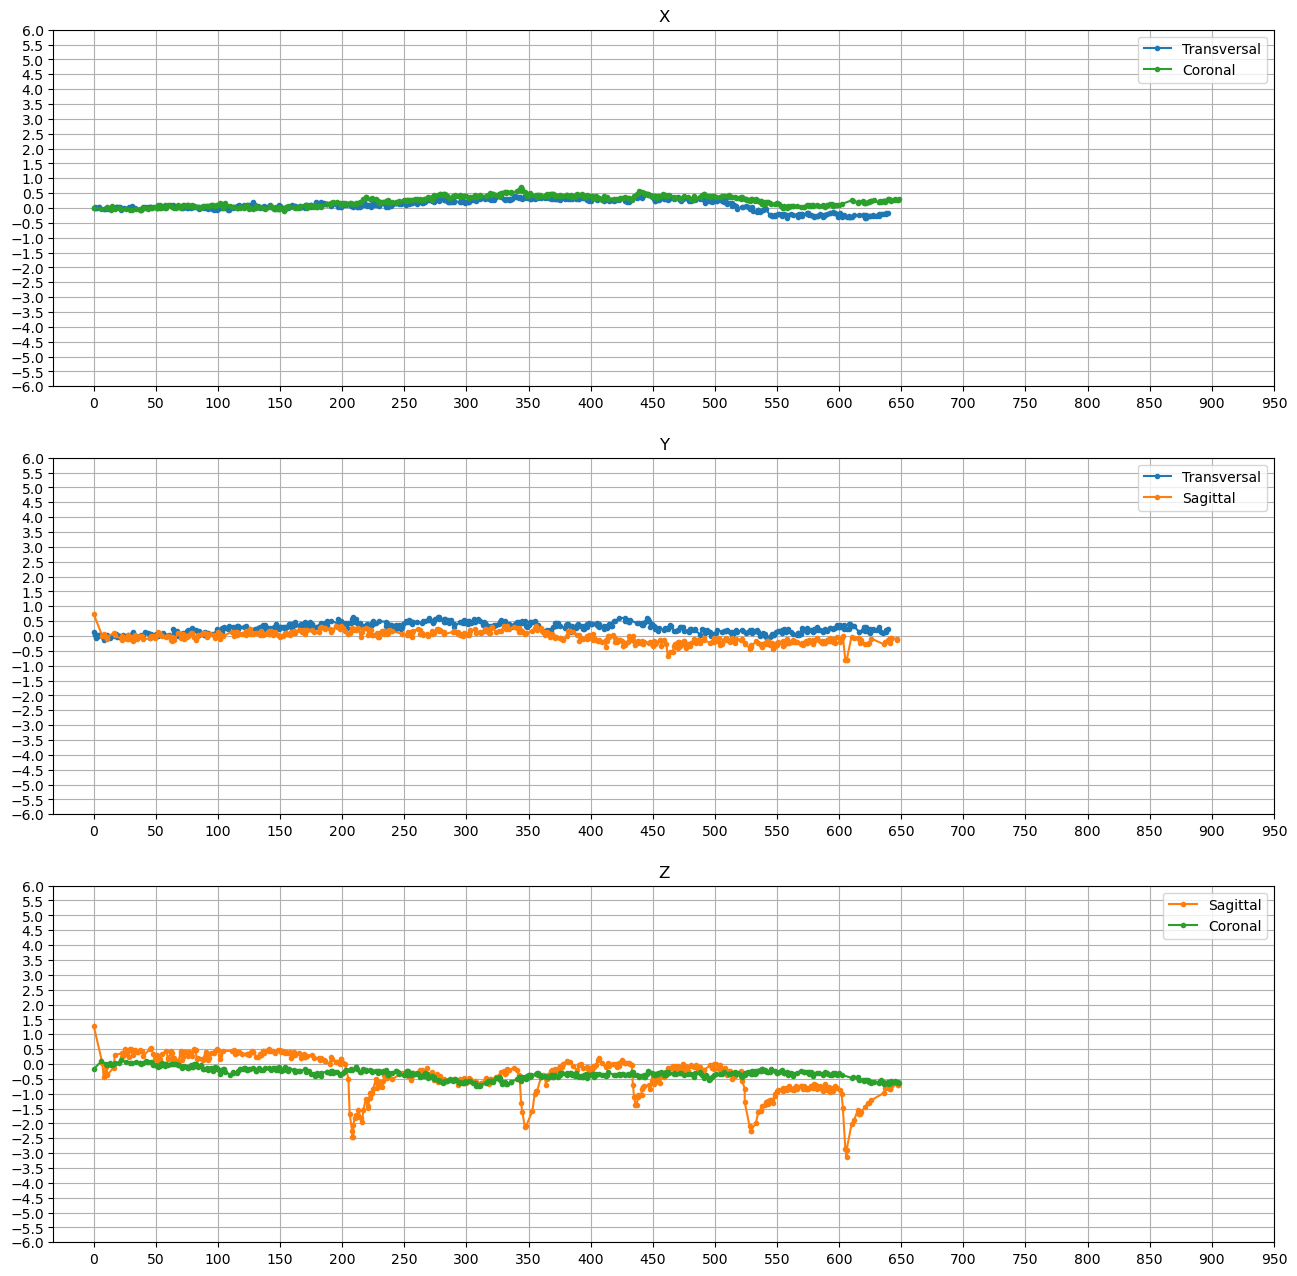

In [8]:


f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(40/2.54, 40/2.54))

motion_statistics(displacements_transversal, displacements_sagittal, displacements_coronal, percentile=0.98)

ax1.plot(time_transversal, displacements_transversal[:,0], label='Transversal', color='C0', marker='o', markersize=3)
ax2.plot(time_transversal, displacements_transversal[:,1], label='Transversal', color='C0', marker='o', markersize=3)
#ax2.scatter(t_transversal, displacements_transversal[:,1], color='C0')

ax2.plot(time_sagittal, displacements_sagittal[:,0], label='Sagittal', color='C1', marker='o', markersize=3)
ax3.plot(time_sagittal, displacements_sagittal[:,1], label='Sagittal', color='C1', marker='o', markersize=3)

ax1.plot(time_coronal, displacements_coronal[:,0], label='Coronal', color='C2', marker='o', markersize=3)
ax3.plot(time_coronal, displacements_coronal[:,1], label='Coronal', color='C2', marker='o', markersize=3)

ax1.set_title('X')
ax2.set_title('Y')   
ax3.set_title('Z')

for ax in [ax1, ax2, ax3]:
    ax.legend()
    ax.set_ylim([-6,6])
    ax.grid()
    ax.set_xticks(np.arange(0, 1000, 50)) 
    ax.set_yticks(np.arange(-6, 6.1, 0.5)) 


#[[p, transformParameterMap[p]] for p in transformParameterMap]


#t_coronal

In [13]:
len(cines_transversal_cropped)

177

In [14]:
import ipywidgets

def display_images_with_alpha(alpha, fixed, moving, registered):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20/2.54, 15/2.54))
    
    fixed_f = sitk.Cast(fixed, sitk.sitkFloat32)
    moving_f = sitk.Cast(moving, sitk.sitkFloat32)
    registered_f = sitk.Cast(registered, sitk.sitkFloat32)

    blended = (1.0 - alpha) * fixed_f + alpha * moving_f
    ax1.imshow(sitk.GetArrayViewFromImage(blended), cmap=plt.cm.Greys_r)
    ax1.axis("off")
    ax1.set_title('Fixed <--> Moving', fontsize=24)

    blended = (1.0 - alpha) * fixed_f + alpha * registered_f
    ax2.imshow(sitk.GetArrayViewFromImage(blended), cmap=plt.cm.Greys_r)
    ax2.axis("off")
    ax2.set_title('Fixed <--> Registered', fontsize=24)
    
    fig.tight_layout()
    plt.show()


#ipywidgets.interact(
#    display_images_with_alpha,
#    alpha=(0, 1.),
#    fixed=ipywidgets.fixed(fixed_image),
#    moving=ipywidgets.fixed(moving_image),
#    registered=ipywidgets.fixed(registered_image),
#);



In [15]:
parameter_map = sitk.GetDefaultParameterMap('groupwise')
[[parameter, parameter_map[parameter]] for parameter in parameter_map]

[['AutomaticParameterEstimation', ('true',)],
 ['CheckNumberOfSamples', ('true',)],
 ['DefaultPixelValue', ('0.0',)],
 ['FinalBSplineInterpolationOrder', ('3',)],
 ['FinalGridSpacingInPhysicalUnits', ('8.000000',)],
 ['FixedImagePyramid', ('FixedSmoothingImagePyramid',)],
 ['GridSpacingSchedule', ('2.803221', '1.988100', '1.410000', '1.000000')],
 ['ImageSampler', ('RandomCoordinate',)],
 ['Interpolator', ('ReducedDimensionBSplineInterpolator',)],
 ['MaximumNumberOfIterations', ('256',)],
 ['MaximumNumberOfSamplingAttempts', ('8',)],
 ['Metric', ('VarianceOverLastDimensionMetric',)],
 ['MovingImagePyramid', ('MovingSmoothingImagePyramid',)],
 ['NewSamplesEveryIteration', ('true',)],
 ['NumberOfResolutions', ('4',)],
 ['NumberOfSamplesForExactGradient', ('4096',)],
 ['NumberOfSpatialSamples', ('2048',)],
 ['Optimizer', ('AdaptiveStochasticGradientDescent',)],
 ['Registration', ('MultiResolutionRegistration',)],
 ['ResampleInterpolator', ('FinalReducedDimensionBSplineInterpolator',)],
 [

In [16]:
parameter_map = sitk.GetDefaultParameterMap('translation')
[[parameter, parameter_map[parameter]] for parameter in parameter_map]

[['AutomaticParameterEstimation', ('true',)],
 ['AutomaticTransformInitialization', ('true',)],
 ['CheckNumberOfSamples', ('true',)],
 ['DefaultPixelValue', ('0.0',)],
 ['FinalBSplineInterpolationOrder', ('3',)],
 ['FixedImagePyramid', ('FixedSmoothingImagePyramid',)],
 ['ImageSampler', ('RandomCoordinate',)],
 ['Interpolator', ('LinearInterpolator',)],
 ['MaximumNumberOfIterations', ('256',)],
 ['MaximumNumberOfSamplingAttempts', ('8',)],
 ['Metric', ('AdvancedMattesMutualInformation',)],
 ['MovingImagePyramid', ('MovingSmoothingImagePyramid',)],
 ['NewSamplesEveryIteration', ('true',)],
 ['NumberOfResolutions', ('4',)],
 ['NumberOfSamplesForExactGradient', ('4096',)],
 ['NumberOfSpatialSamples', ('2048',)],
 ['Optimizer', ('AdaptiveStochasticGradientDescent',)],
 ['Registration', ('MultiResolutionRegistration',)],
 ['ResampleInterpolator', ('FinalBSplineInterpolator',)],
 ['Resampler', ('DefaultResampler',)],
 ['ResultImageFormat', ('nii',)],
 ['Transform', ('TranslationTransform',)]

In [17]:
sitk.PrintParameterMap(transformParameterMap)

print()

#transformParameterMap['TransformParameters']
type(transformParameterMap)

NameError: name 'transformParameterMap' is not defined